In [ ]:
%%capture
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json

import copy
from astropy.io import fits
from scipy import interpolate

import healpy as hp
import component_separation
from component_separation.io import IO
import component_separation.interface as cslib
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw

from component_separation.cs_util import Config
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
csu = Config()
io = IO(csu)
import warnings
warnings.filterwarnings('ignore')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

lmax=csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.PLANCKMAPFREQ_f
specfilter = csu.specfilter
freqfilter = csu.freqfilter
lmaxbins = int(bins[-1][1])
colors=csu.CB_color_cycle

In [54]:
CMB_n = io.load_data(io.fh.map_cmb_sc_path_name)
MV_n = io.load_data(io.fh.cmbmap_smica_path_name)
smica_cmb_cl = io.load_data(io.fh.cmb_specsmica_sc_path_name)

W_smica = io.load_data(io.fh.weight_smica_path_name)
W_mv = io.load_data(io.fh.weight_path_name)

cfc = copy.deepcopy(csu.cf)
cfc['pa']['freqdset'] = 'DX12'
csuc = Config(cfc)
ioc = IO(csuc)

CMB_d = ioc.load_data(ioc.fh.map_cmb_sc_path_name)
MV_d = ioc.load_data(ioc.fh.cmbmap_smica_path_name)

pure_cmb_cl = io.load_data(io.fh.signal_sc_path_name)
pure_cmb_map = io.load_data(io.fh.map_cmb_sc_path_name)
smica_cmb_cl = io.load_data(io.fh.cmb_specsmica_sc_path_name)

loaded /global/cscratch1/sd/sebibel/misc/map_cmb_in_nside_2048_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/smicaminvarmap_SMICA_highell_bins_0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/CMB_SPECSMICA_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Run with the following settings:
{'Tscale': 'K_CMB', 'mskset': 'smica', 'freqdset': 'DX12', 'Spectrum_scale': 'C_l', 'lmax': 4000, 'lmax_mask': 6000, 'freqdatsplit': '', 'smoothing_window': 0, 'max_polynom': 0, 'num_sim': 5, 'binname': 'SMICA_highell_bins', 'overwrite_cache': True, 'split': '', 'nside_out': None, 'splitvariation': 'GHz', 'freqfilter': ['545', '857'], 'specfilter': ['TB', 'EB', 'ET', 'BT', 'BE'], 'nside_desc_map': [1024, 2048]}
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
loaded /global/cscratch1/sd/sebibel/misc/map_cmb_in_nside_2048_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/smicaminvarmap_SMICA_highe

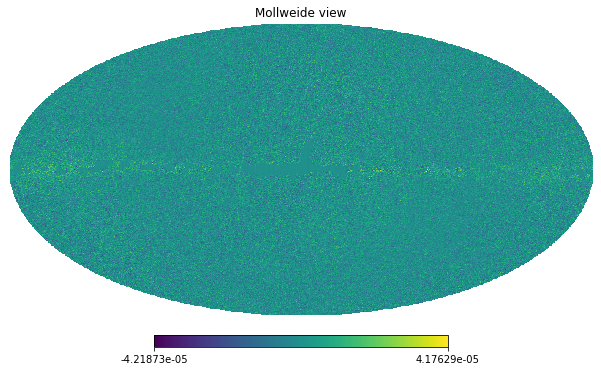

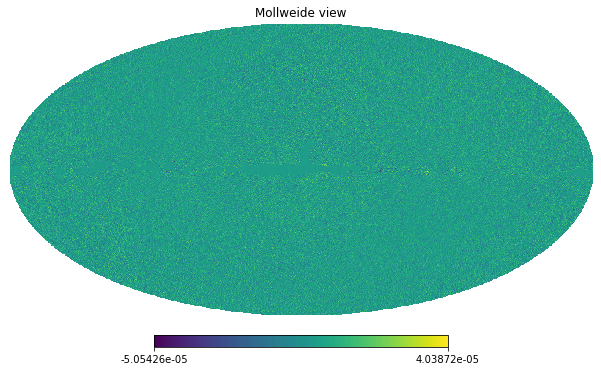

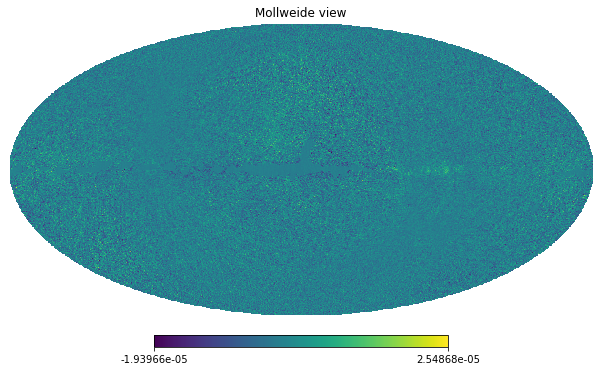

In [7]:
# hp.mollview(MV_d[2])
hp.mollview(MV_n[1])
hp.mollview(MV_n[2])
hp.mollview(MV_d[2]-MV_n[2])

In [14]:
lmaxbin = int(bins[-1][1]+1)

W_total = np.zeros(shape=(*W_mv.shape[:-1], csu.lmax))
xnew = np.arange(0,lmaxbin+1,1)
for it, det in enumerate(csu.PLANCKMAPFREQ): #weights do not depend on freqfilter, but almE/B do
    if det in csu.PLANCKMAPFREQ_f:
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        W_Einterp = interpolate.interp1d(np.mean(bins, axis=1), W_smica[1,it,:], bounds_error = False, fill_value='extrapolate')
        W_total[0,it] = np.concatenate((W_Einterp(xnew),W_mv[1,it,xnew.shape[0]+1:]))

loaded /global/cscratch1/sd/sebibel/smica/SMICAWEIG_K_CMB_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/weights/NPIPE/WEIG_K_CMB_0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy


030
044
070
100
143
217
353


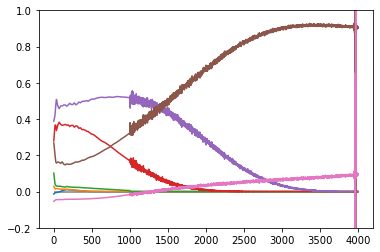

In [15]:
for freq in range(0, 7):
    freqc = '-'.join([csu.PLANCKMAPFREQ[freq],csu.PLANCKMAPFREQ[freq]])
    print(csu.PLANCKMAPFREQ[freq])
    plt.plot(W_total[0,freq,:])
plt.ylim((-0.2,1))
plt.hlines(0,lmax,0, color='grey')

In [16]:
CMB = dict()
CMB["TQU"] = dict()
almT, almE, almB = dict(), dict(), dict()
maps = io.load_plamap(csu.cf, field=(0,1,2), nside_out=csu.nside_out)
tmask, pmask, pmask =  io.load_one_mask_forallfreq()
beamf = io.load_beamf(freqcomb=csu.freqcomb)

loaded {'030': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_030_map.fits', '044': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_044_map.fits', '070': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_070_map.fits', '100': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_100_map.fits', '143': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_143_map.fits', '217': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_217_map.fits', '353': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_353_map.fits'}
loading mask ['psmaskP_2048.fits.gz', 'gmaskP_apodized_0_2048.fits.gz']


In [17]:
for freq in csu.PLANCKMAPFREQ_f:
    print('freq: ', freq)
    ns = csu.nside_out[0] if int(freq) < 100 else csu.nside_out[1]
    alms = pw.map2alm_spin(maps[freq], hp.ud_grade(pmask[freq], nside_out=ns), 2, lmax-1) # full sky QU->EB
    # almT[det] = alms[0]
    almE[freq] = alms[0]
    almB[freq] = alms[1]

nalm = int((lmax)*(lmax-1+2)/2)  
# combalmT = np.zeros((nalm), dtype=np.complex128)
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)

freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [52]:
for it, det in enumerate(csu.PLANCKMAPFREQ): #weights do not depend on freqfilter, but almE/B do
    if det in csu.PLANCKMAPFREQ_f:
        print('freq: ', det)
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        # combalmT += hp.almxfl(almT[name], np.squeeze(W[0,m,:]))
        LHFI = "LFI" if int(det)<100 else "HFI"
        if csu.cf['pa']['freqdset'].startswith('NPIPE'):
            LHFI = "HFI"
        combalmE += hp.almxfl(hp.almxfl(almE[det],1/beamf[str(det)+'-'+str(det)][LHFI][1].data.field(1)[:lmax]), np.squeeze(W_total[0,it,:]))
        combalmE = hp.almxfl(combalmE, 1/hp.pixwin(ns, pol=True)[0][:lmax])
        combalmB += hp.almxfl(hp.almxfl(almB[det],1/beamf[str(det)+'-'+str(det)][LHFI][1].data.field(2)[:lmax]), np.squeeze(W_total[0,it,:]))
        combalmB = hp.almxfl(combalmB, 1/hp.pixwin(ns, pol=True)[1][:lmax])

freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [63]:
CMB["TQU"]['out'] = hp.alm2map(hp.smoothalm([np.zeros_like(combalmE), combalmE, combalmB], fwhm=np.radians(80/60)), csu.nside_out[1])

(1e-20, 1e-10)

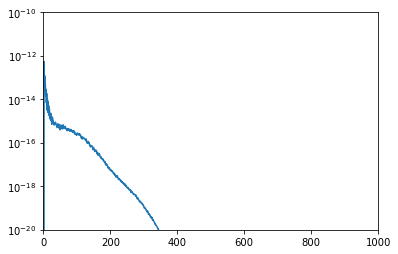

In [82]:
mv_cl = hp.alm2cl([np.zeros_like(combalmE), combalmE, combalmB])
plt.plot(mv_cl[1])
plt.yscale('log')
plt.xlim((0,1000))
plt.ylim((1e-20,1e-10))
# plt.ylim((1e-16,1e-14))

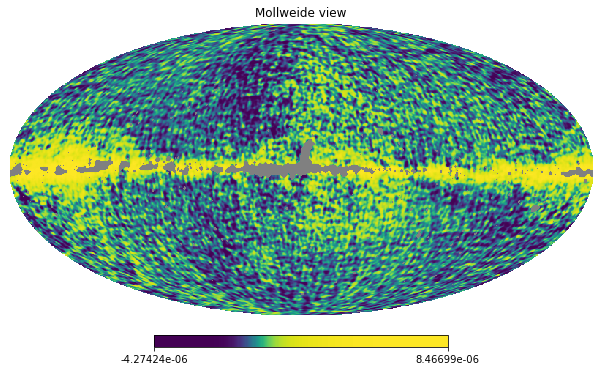

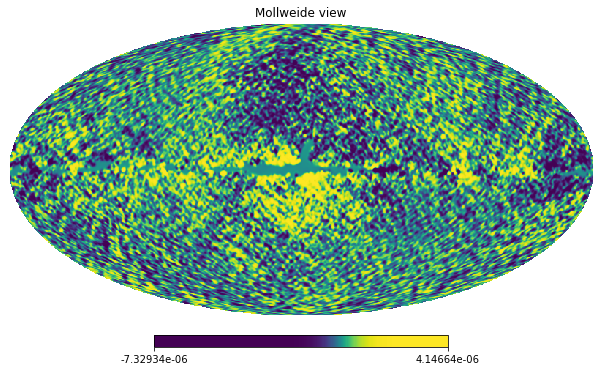

In [83]:
ma = hp.ma(CMB["TQU"]['out'][1])
ma.mask = np.logical_not(pmask['100'].astype(np.bool_))
hp.mollview(ma, norm='hist')
hp.mollview(CMB["TQU"]['out'][2], norm='hist')

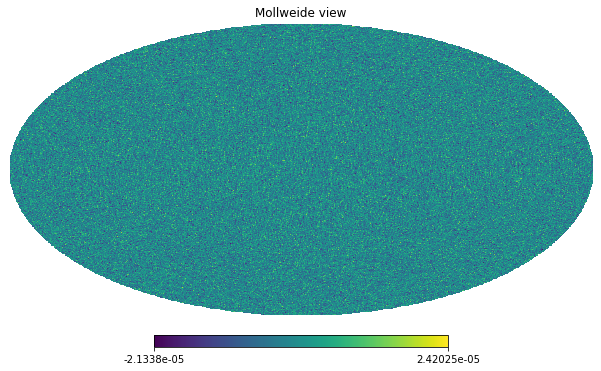

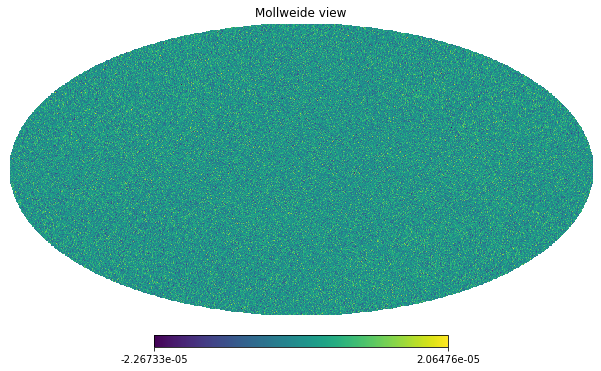

In [58]:
hp.mollview(pure_cmb_map[1])
hp.mollview(pure_cmb_map[2])

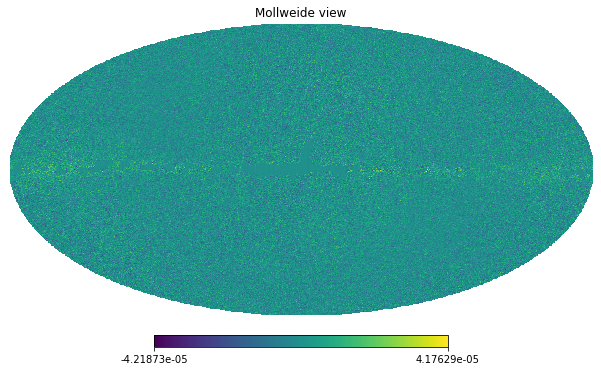

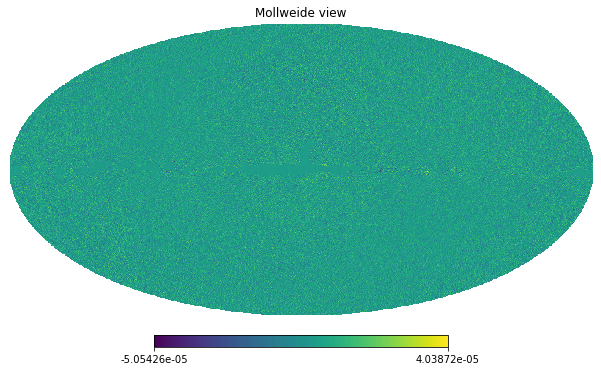

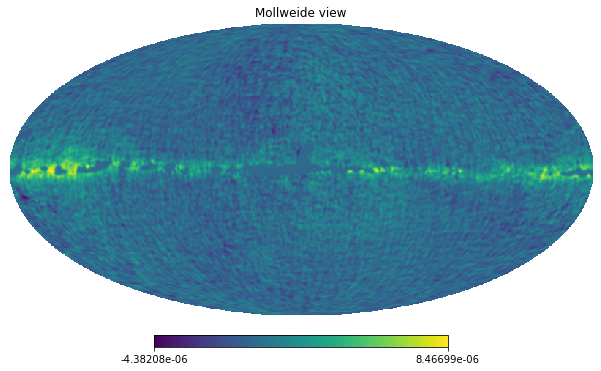

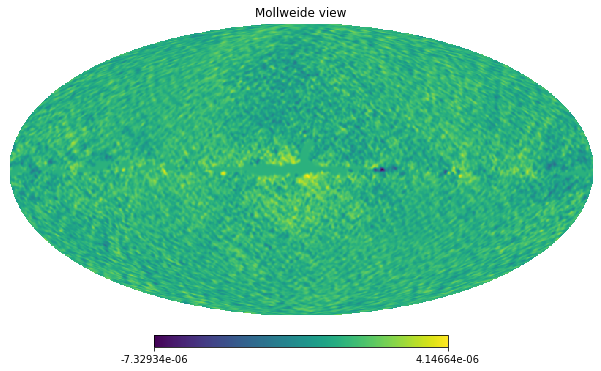

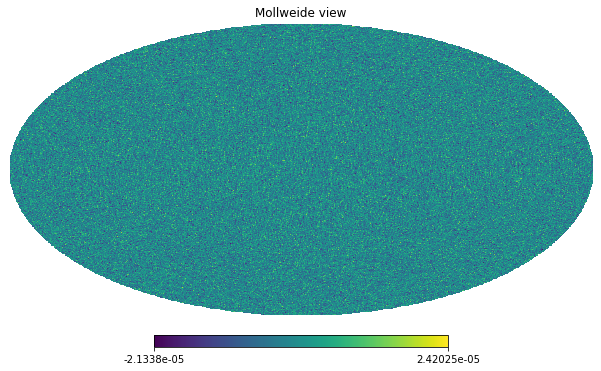

In [84]:
hp.mollview(MV_n[1])
hp.mollview(MV_n[2])
hp.mollview(CMB["TQU"]['out'][1])
hp.mollview(CMB["TQU"]['out'][2])
hp.mollview(pure_cmb_map[1])

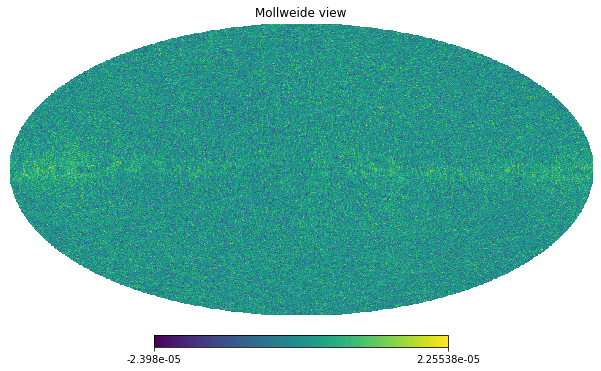

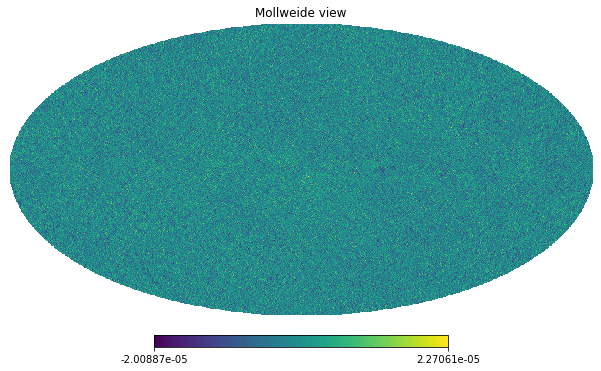

In [72]:
residual_map = CMB["TQU"]['out']-pure_cmb_map
hp.mollview(residual_map[1])
hp.mollview(residual_map[2])

In [73]:
residual_cl = hp.anafast(residual_map)

(0.0, 1000.0)

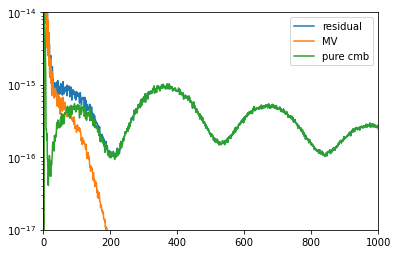

In [85]:
plt.plot(residual_cl[1], label= 'residual')
plt.plot(mv_cl[1], label='MV')
plt.plot(pure_cmb_cl[0][1]*1e-12, label='pure cmb')
plt.yscale('log')
plt.legend()
plt.ylim((1e-17,1e-14))
plt.xlim((0,1000))

(0.0, 1000.0)

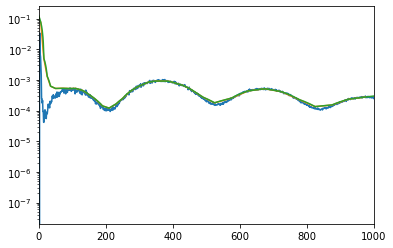

In [86]:
plt.plot(pure_cmb_cl[0,1])
plt.plot(np.mean(bins, axis=1), smica_cmb_cl[0,0])
plt.plot(smica_cmb_cl_interp(xnew))
plt.yscale('log')

plt.xlim((0,1000))

In [48]:
xnew = np.arange(0,lmax+1,1)
smica_cmb_cl_interp = interpolate.interp1d(np.mean(bins, axis=1), smica_cmb_cl[0,0], bounds_error = False, fill_value='extrapolate')

In [50]:
smica_cmb_map = hp.synfast(smica_cmb_cl_interp(xnew), nside=2048)
pure_cmb_map = hp.synfast(cmb_cl[0,1], nside=2048)

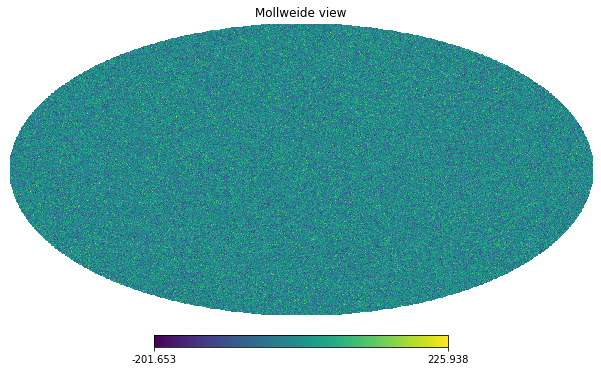

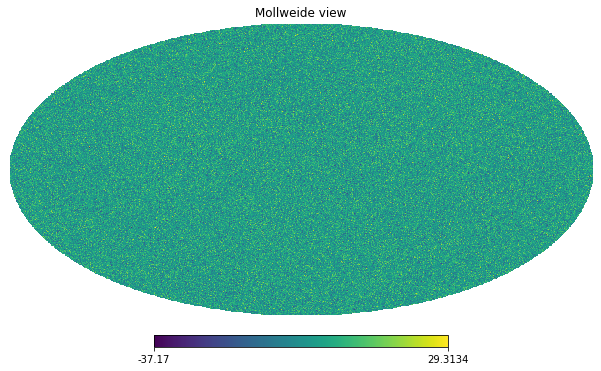

In [51]:
hp.mollview(smica_cmb_map)
hp.mollview(pure_cmb_map)

In [44]:
smica_cmb_cl_interp(xnew).shape

(1, 1, 4001)